**FINE TUNING**

The task of fine-tuning a network is to tweak the parameters of an already trained network so that it adapts to the new task at hand. We will use the VGG16 model for fine-tuning.

In [25]:
# Load the pre-trained model - First, we will load a VGG model without the top layer ( which consists of fully connected layers ).

from keras.applications import VGG16

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_conv.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [26]:
# Freeze the required layers-In Keras, each layer has a parameter called “trainable”. For freezing the weights of a particular layer, we should set this parameter
# to False, indicating that this layer should not be trained. That’s it! We go over each layer and select which layers we want to train.

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers

for layer in vgg_conv.layers:
    print(layer, layer.trainable)
    


<keras.engine.topology.InputLayer object at 0x7f89e9e9ee48> False
<keras.layers.convolutional.Conv2D object at 0x7f89e9e9ea58> False
<keras.layers.convolutional.Conv2D object at 0x7f89e9e9e5f8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f89ec2f0208> False
<keras.layers.convolutional.Conv2D object at 0x7f89ec2f0780> False
<keras.layers.convolutional.Conv2D object at 0x7f89ec326898> False
<keras.layers.pooling.MaxPooling2D object at 0x7f89e9e9b908> False
<keras.layers.convolutional.Conv2D object at 0x7f89ec6e81d0> False
<keras.layers.convolutional.Conv2D object at 0x7f89ec2eacc0> False
<keras.layers.convolutional.Conv2D object at 0x7f89ec2bd160> False
<keras.layers.pooling.MaxPooling2D object at 0x7f89ec7f73c8> False
<keras.layers.convolutional.Conv2D object at 0x7f89ec749588> False
<keras.layers.convolutional.Conv2D object at 0x7f89ebb84d30> False
<keras.layers.convolutional.Conv2D object at 0x7f89e9f950b8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f89eb67a7f0> Fa

In [27]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [28]:
# The data is divided into 80:20 ratio and kept in separate train and validation folders. 

train_dir = 'drive/My Drive/train/'

validation_dir = 'drive/My Drive/validation/'

print(train_dir)
print(validation_dir)


nTrain = 1088
nVal = 272

drive/My Drive/train/
drive/My Drive/validation/


In [29]:
# Create a new model - Now that we have set the trainable parameters of our base network, we would like to add a classifier on top of the convolutional base. 
# We will simply add a fully connected layer followed by a softmax layer with 17 outputs. This is done as given below.

from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_15 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 17)                17425     
Total params: 40,423,249
Trainable params: 32,787,985
Non-trainable params: 7,635,264
_________________________________________________________________


In [6]:
# Setup the data generators - We have already separated the data into train and validation and kept it in the “train” and “validation” folders. We can use 
# ImageDataGenerator available in Keras to read images in batches directly from these folders and optionally perform data augmentation. We will use two different 
# data generators for train and validation folders.

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
print(tf.__version__)
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224,224),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224,224),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)





1.12.0-rc1
Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


In [7]:
# Train the model - We will have to specify the optimizer and the learning rate and start training using the model.fit() function. 
# After the training is over, we will save the model.

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# Save the model
model.save('small_last4.h5')

Epoch 1/30
11/10 [==============================] - 552s 50s/step - loss: 2.7444 - acc: 0.1578 - val_loss: 1.9147 - val_acc: 0.3750
Epoch 2/30
11/10 [==============================] - 15s 1s/step - loss: 1.7284 - acc: 0.4572 - val_loss: 1.3284 - val_acc: 0.5699
Epoch 3/30
11/10 [==============================] - 27s 2s/step - loss: 1.0773 - acc: 0.6745 - val_loss: 1.1152 - val_acc: 0.6397
Epoch 4/30
11/10 [==============================] - 26s 2s/step - loss: 0.8471 - acc: 0.7470 - val_loss: 0.6962 - val_acc: 0.7831
Epoch 5/30
11/10 [==============================] - 26s 2s/step - loss: 0.6240 - acc: 0.7913 - val_loss: 0.5404 - val_acc: 0.8382
Epoch 6/30
11/10 [==============================] - 26s 2s/step - loss: 0.4674 - acc: 0.8505 - val_loss: 0.4244 - val_acc: 0.8603
Epoch 7/30
11/10 [==============================] - 26s 2s/step - loss: 0.3888 - acc: 0.8695 - val_loss: 0.3930 - val_acc: 0.8750
Epoch 8/30
11/10 [==============================] - 26s 2s/step - loss: 0.3022 - acc: 0.

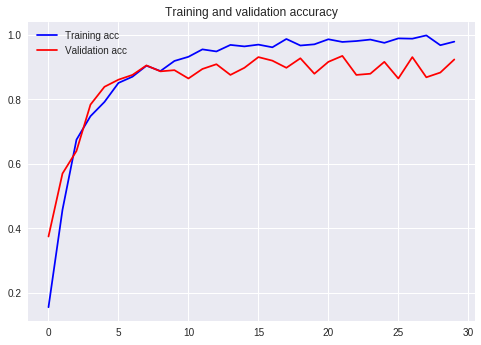

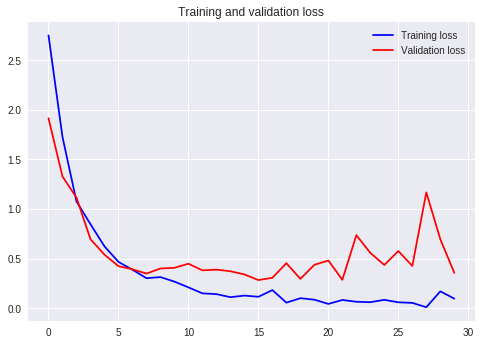

In [8]:
# Check Performance - We obtained an accuracy of 90% with the transfer learning approach discussed in our previous blog. Here we are getting a much better 
# accuracy of 98%.

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Found 272 images belonging to 17 classes.
28/27 [==============================] - 4s 135ms/step
No of errors = 21/272


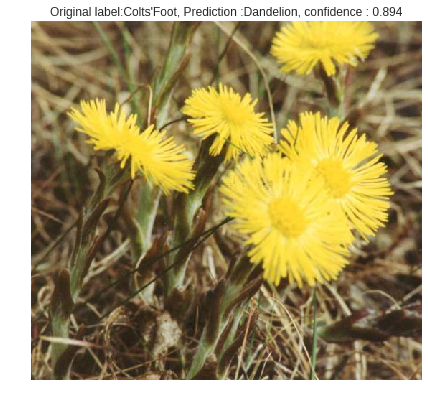

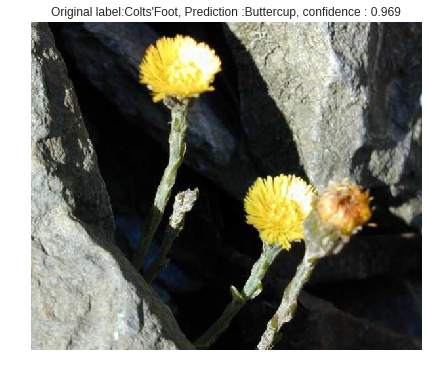

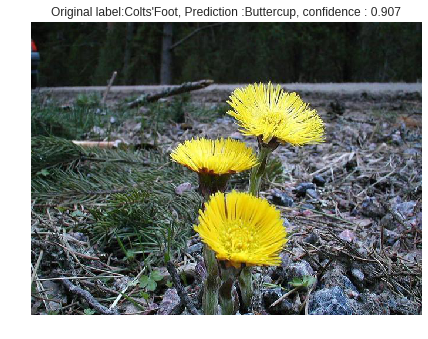

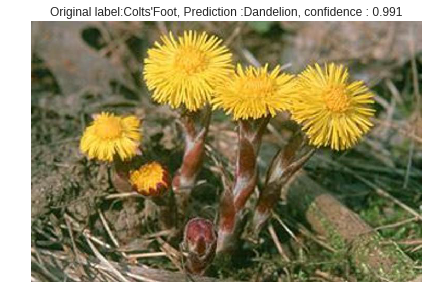

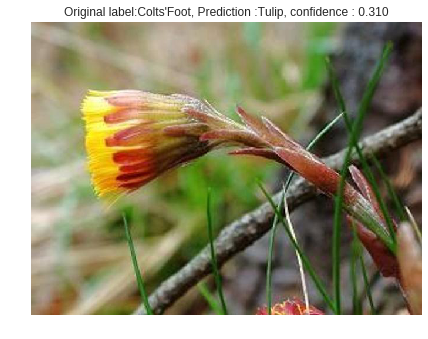

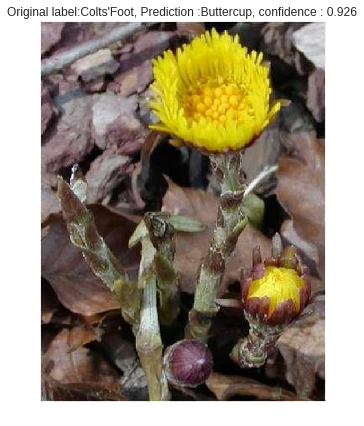

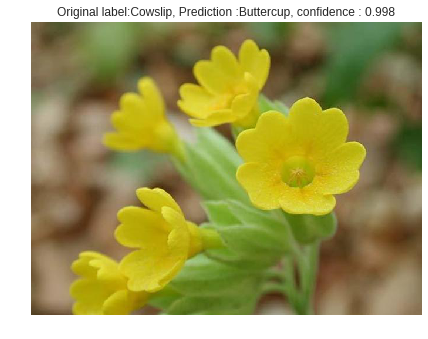

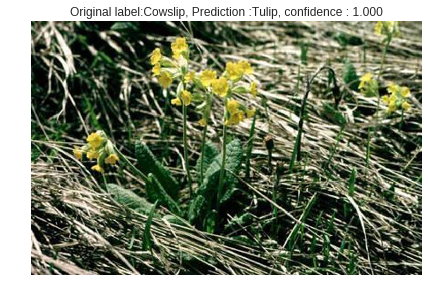

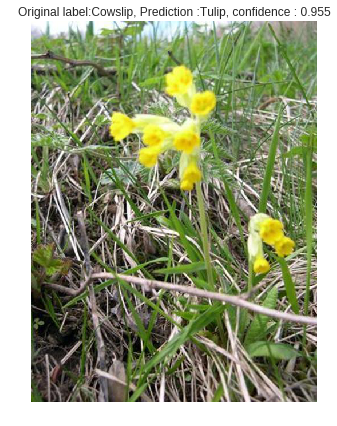

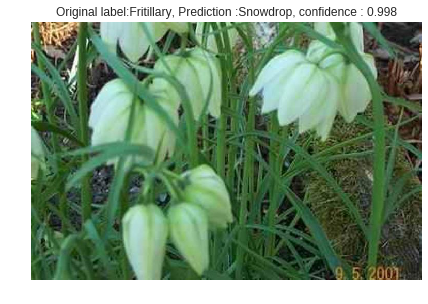

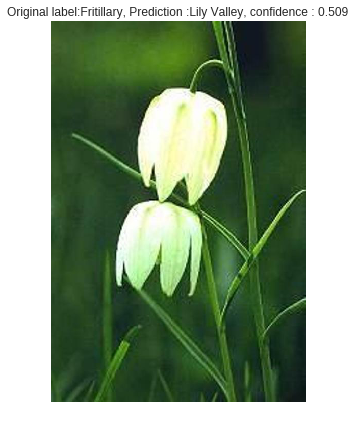

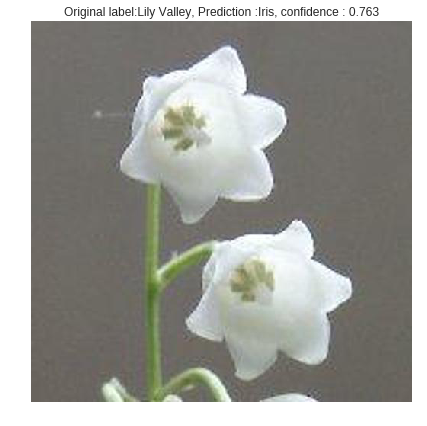

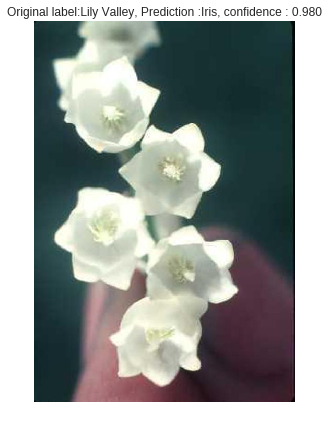

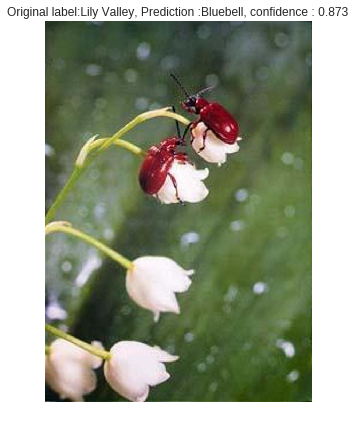

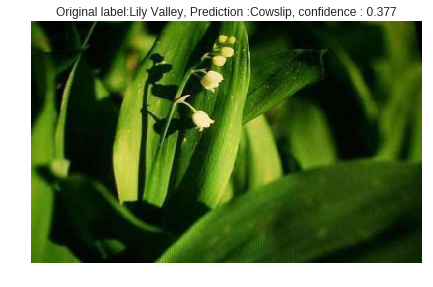

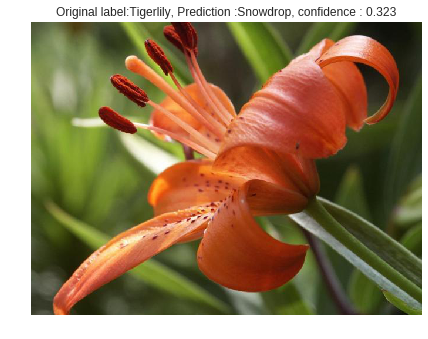

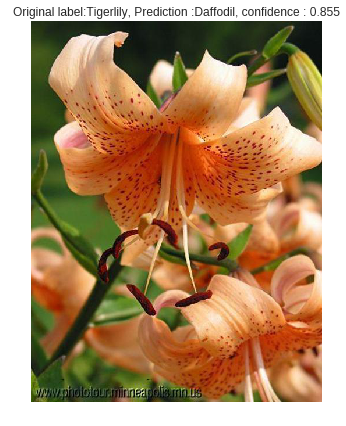

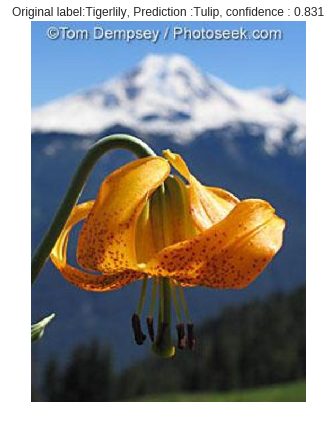

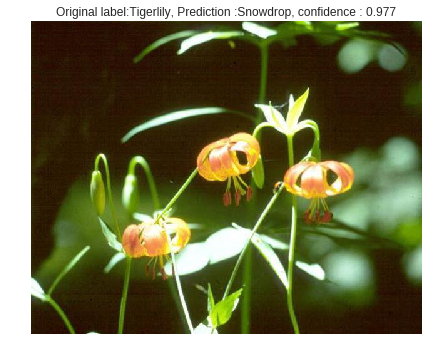

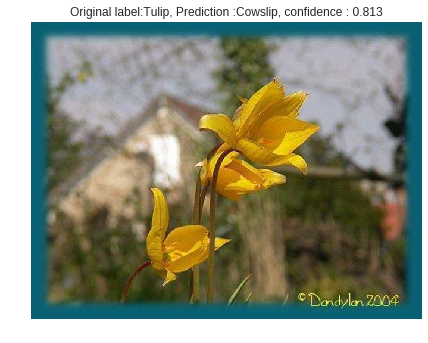

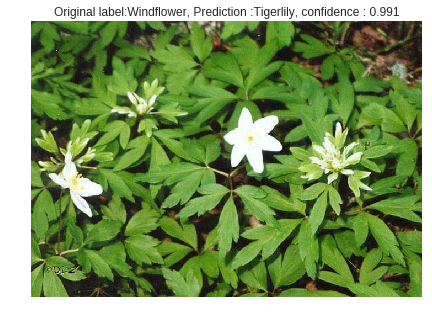

In [9]:
# Create a generator for prediction

from keras.preprocessing import image

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = image.load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

In [31]:
# TOP 1 ACCURACY

from keras import models
from keras import layers
from keras import optimizers
from keras.metrics import top_k_categorical_accuracy


# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='softmax'))

# Top 1 accuracy used as Metrics 

def top_1_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=1) 

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=[top_1_categorical_accuracy])

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/30
11/10 [==============================] - 30s 3s/step - loss: 2.8717 - top_1_categorical_accuracy: 0.1694 - val_loss: 1.9610 - val_top_1_categorical_accuracy: 0.4963
Epoch 2/30
11/10 [==============================] - 26s 2s/step - loss: 1.8138 - top_1_categorical_accuracy: 0.4150 - val_loss: 1.1021 - val_top_1_categorical_accuracy: 0.6801
Epoch 3/30
11/10 [==============================] - 26s 2s/step - loss: 1.2008 - top_1_categorical_accuracy: 0.6176 - val_loss: 0.7233 - val_top_1_categorical_accuracy: 0.7831
Epoch 4/30
11/10 [==============================] - 26s 2s/step - loss: 0.8525 - top_1_categorical_accuracy: 0.7326 - val_loss: 0.5825 - val_top_1_categorical_accuracy: 0.8051
Epoch 5/30
11/10 [==============================] - 26s 2s/step - loss: 0.6201 - top_1_categorical_accuracy: 0.8128 - val_loss: 0.8132 - val_top_1_categorical_accuracy: 0.7868
Epoch 6/30
11/10 [==============================] - 26s 2s/step - loss: 0.5254 - top_1_categorical_accuracy: 0.8460 - va

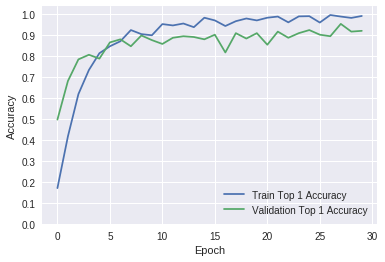

In [32]:
# TOP 1 ACCURACY PLOT

import matplotlib.pyplot as plt
%matplotlib inline
def plot_history(history):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy')
 plt.plot(history.epoch, np.array(history.history['top_1_categorical_accuracy']),
 label='Train Top 1 Accuracy')
 plt.plot(history.epoch, np.array(history.history['val_top_1_categorical_accuracy']),
 label = 'Validation Top 1 Accuracy')
 plt.legend()
 plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])    
    
plot_history(history)

In [33]:
# TOP 5 ACCURACY

from keras import models
from keras import layers
from keras import optimizers
from keras.metrics import top_k_categorical_accuracy

# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='softmax'))

# Top 5 accuracy used as Metrics 

def top_5_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5) 

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=[top_5_categorical_accuracy])

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/30
11/10 [==============================] - 29s 3s/step - loss: 1.1246 - top_5_categorical_accuracy: 0.8710 - val_loss: 0.3742 - val_top_5_categorical_accuracy: 0.9743
Epoch 2/30
11/10 [==============================] - 26s 2s/step - loss: 0.2086 - top_5_categorical_accuracy: 0.9936 - val_loss: 0.8173 - val_top_5_categorical_accuracy: 0.9706
Epoch 3/30
11/10 [==============================] - 26s 2s/step - loss: 0.2124 - top_5_categorical_accuracy: 0.9973 - val_loss: 0.5879 - val_top_5_categorical_accuracy: 0.9743
Epoch 4/30
11/10 [==============================] - 26s 2s/step - loss: 0.0651 - top_5_categorical_accuracy: 1.0000 - val_loss: 0.5138 - val_top_5_categorical_accuracy: 0.9706
Epoch 5/30
11/10 [==============================] - 26s 2s/step - loss: 0.1102 - top_5_categorical_accuracy: 0.9991 - val_loss: 0.4501 - val_top_5_categorical_accuracy: 0.9890
Epoch 6/30
11/10 [==============================] - 26s 2s/step - loss: 0.0655 - top_5_categorical_accuracy: 1.0000 - va

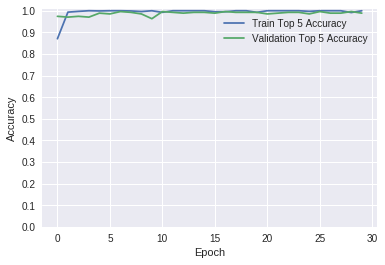

In [35]:
# TOP 5 ACCURACY PLOT

import matplotlib.pyplot as plt
%matplotlib inline
def plot_history(history):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy')
 plt.plot(history.epoch, np.array(history.history['top_5_categorical_accuracy']),
 label='Train Top 5 Accuracy')
 plt.plot(history.epoch, np.array(history.history['val_top_5_categorical_accuracy']),
 label = 'Validation Top 5 Accuracy')
 plt.legend()
 plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])    
    
plot_history(history)

**Frozen Layers for training & New custom layers -** The pre-trained convolution neural network, used here is VGG16. Fine tuning has been applied on this pre-trained VGG16 model for the purpose of classifying 17 categories of flowers, which has a total of 1360 images. In the current model, the last 4 layers from CNN is removed and the learning from the rest of the layers are transferred to our feedforward network. The new custom layers in the feedforward networks are trained by first freezing all layers, except the last 4 layers, from CNN, whose learnings were transferred. It is essential to freeze these pre-trained layers so that these layers will not lose their learning while the new custom layers get trained. Data augmentation has also been used in the model. The top 1 accuracy got for fine tuning is 91% and the top 5 accuracy got is 98%.